# Cloning via Offline Backups

Cloning items from one organization has long been an important workflow in the ArcGIS API for Python, primarily through [`clone_items()`](/python/latest/guide/cloning-content/). The [`clone_items()`](/python/latest/api-reference/arcgis.gis.toc.html#arcgis.gis.ContentManager.clone_items) method depends on having multiple active GIS connections, and items are dissected and reconstructed from scratch within each call. The [`OfflineContentManager`](/python/latest/api-reference/arcgis.gis.toc.html#offlinecontentmanager) (OCM) module, introduced in version 2.4.1, takes a slightly different approach. While both can take part and reassemble items elsewhere, the `OfflineContentManager` also creates a compressed backup of the items along the way, including all dependencies of the items being cloned.

See the the API reference documentation for the module [here](https://developers.arcgis.com/python/latest/api-reference/arcgis.gis.toc.html#offlinecontentmanager).

The module is compact, and an object of the `OfflineContentManager` class can be accessed through the [`offline`](/python/latest/api-reference/arcgis.gis.toc.html#arcgis.gis.ContentManager.offline) property of a [ContentManager](/python/latest/api-reference/arcgis.gis.toc.html#contentmanager) object: `gis.content.offline`. It consists of 3 methods: 
* [`export_items()`](/python/latest/api-reference/arcgis.gis.toc.html#arcgis.gis.OfflineContentManager.export_items) - to export item content to a package
* [`import_content()`](/python/latest/api-reference/arcgis.gis.toc.html#arcgis.gis.OfflineContentManager.import_content) - one to import package content 
* [`list_items()`](/python/latest/api-reference/arcgis.gis.toc.html#arcgis.gis.OfflineContentManager.list_items) - to explore the content of a compressed backup.

The way it works behind the scenes is:
- In `export_items()`, an [`ItemGraph`](/python/latest/api-reference/arcgis.apps.itemgraph.html#itemgraph) is assembled with all of the items and the items they need to exist
- An output folder is generated, and within that, a folder for each item is created with the necessary data and metadata. Services without an underlying feature class file are exported to a File Geodatabase by default, or the format specified in the export call's `service_format` argument.
- That output folder is compressed and stored either in the specified path or in a temporary directory
- On import, the the package is decompressed, the graph is recreated in memory, and the items are created in order from least dependencies to most

There are a few situations where it may be advantageous to use this module instead of `clone_items()`. Creating a singular backup to use from a source org can avoid repeated calls to `clone_items()` in cases where content is being brought to multiple different GIS orgs. Additionally, creating backup packages provides safety against unexpected changes to an organization's content. Another notable difference between the OCM and `clone_items()` is that the `import_content()` method provides the option to skip over items that aren't recreated correctly, as opposed to rolling everything back like `clone_items()` does.

Let's take a look at its basic usage, and then a couple more specific use cases.

## Step 1: Exporting

We'll start by showing how to create one of these offline packages in our source organization. It's as easy as just selecting the items you wish to export, and passing them into the `export_items()` method. A package with those items and every other item they need to exist will be assembled.

Let's start by connecting to a GIS, and accessing an OfflineContentManager object.

In [3]:
from arcgis.gis import GIS
gis = GIS(profile="your_admin_profile")
ocm = gis.content.offline
ocm

We'll get the item that we want to back up and/or migrate.

<Item title:"Oceanic Experience" type:Web Experience owner:nparavicini_geosaurus>
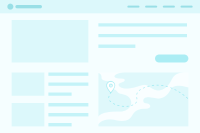

In [5]:
experience = gis.content.get("b2136e64f7414d10b02b52b009d7c13b")
experience

When we call the `export_items()` method, there are a couple things we can dictate: 
* the location the items are exported
* the name of the output package
* whether to export hosted services as a File Geodatabase or Shapefile.

If no path is specified, a package will be created in a temporary file path, and that path can be used for the import.

In [6]:
file_path = ocm.export_items([experience])
file_path

'/var/folders/dn/rybvglf95w710d__8w91yngc0000gn/T/tmph411_rwn/exported_content.contentexport'

## Step 2: Listing Items (Optional)

This second step is optional and is just handy for understanding what exactly was exported into your offline package. This can be helpful for a few different reasons: you're sent a package by somebody else and you'd like to know exactly what was in it, you're exporting complicated items and want to see the full scope of dependencies, or you want to understand what is in the package so you can select a subset to import.

We'll connect to our second GIS and see what was exported by the function in our first GIS.

In [7]:
gis2 = GIS(profile="another_admin_profile")
ocm2 = gis2.content.offline
ocm2.list_items(file_path)

{'b2136e64f7414d10b02b52b009d7c13b': {'title': 'Oceanic Experience',
  'type': 'Web Experience',
  'created': 1721117377000,
  'source': 'https://geosaurus.maps.arcgis.com'},
 'bf5a039b1947422190b5812fc34af717': {'title': 'Ugly Map',
  'type': 'Web Map',
  'created': 1720503733000,
  'source': 'https://geosaurus.maps.arcgis.com'},
 'd322ea73f27844228a2f235d9615854e': {'title': 'CA/OR Airports',
  'type': 'Feature Service',
  'created': 1720503718000,
  'source': 'https://geosaurus.maps.arcgis.com'}}

As we can see, more than just our initial Web Experience got exported- the map contained within the Experience, as well as the Feature Layer displayed within the map, were also exported.

## Step 3: Importing

This is the final and most involved step. Importing the content into the target org is very straightforward, but there are a few options you have to customize the process:
- which specific items to import from a package or all of them
- whether to roll back all item creation on failure, or skip over failed items and continue cloning the rest
- whether to use an `item_mapping` parameter (similar to `clone_items()`) that allows you to replace certain dependencies with existent items

Let's look at a basic call, and then we'll observe the failsafe mechanisms in place when there is an issue encountered importing.

In [8]:
imported = ocm2.import_content(file_path)
imported

[<Item title:"CA/OR Airports" type:File Geodatabase owner:nparavicini>,
 <Item title:"CA/OR Airports" type:Feature Layer Collection owner:nparavicini>,
 <Item title:"Ugly Map" type:Web Map owner:nparavicini>,
 <Item title:"Oceanic Experience" type:Web Experience owner:nparavicini>]

As we can see, the imported content contains an extra item compared to what we started with: a File Geodatabase. We needed to store the data from the feature layer in some offline format, so that is where the file geodatabase comes from.

What if we're importing a larger set of items, and some of them might have issues? For anybody familiar with `clone_items()`, one notable caveat of working with the function is that if any single item fails along the way, all items are rolled back and deleted, meaning a user has to start at square one or find an alternative. Fortunately the `import_content()` method allows users to skip by items that encounter issues. We'll show what happens when cloning a package where some of the items have been corrupted.

In [20]:
fail_path = "/Users/pythondemo/Downloads/ocm_failure.contentexport"
ocm.list_items(fail_path)

{'b13272e4cf334436b1f86ba0137a0aa8': {'title': "Why won't this work?",
  'type': 'StoryMap',
  'created': 1745620980000,
  'source': 'https://geosaurus.maps.arcgis.com'},
 'cb7dd4102c51495e8b4c3a346f03f612': {'title': 'Minnesota_Private_Wells',
  'type': 'Feature Service',
  'created': 1751491976000,
  'source': 'https://geosaurus.maps.arcgis.com'},
 '265de67ceed6498e8cf3fc4a9f795413': {'title': 'Minnesota_Private_Wells',
  'type': 'File Geodatabase',
  'created': 1751491961000,
  'source': 'https://geosaurus.maps.arcgis.com'}}

In [21]:
ocm2.import_content(fail_path)

/Users/pythondemo/packages/arcgis/apps/itemgraph/_migration.py:767: RuntimeWarning: Failed to import item b13272e4cf334436b1f86ba0137a0aa8 due to error: Expected object or value. Skipping...
  warnings.warn(
/Users/pythondemo/packages/arcgis/apps/itemgraph/_migration.py:767: RuntimeWarning: Failed to import item cb7dd4102c51495e8b4c3a346f03f612 due to error: Trailing data. Skipping...
  warnings.warn(


[<Item title:"Minnesota_Private_Wells" type:File Geodatabase owner:nparavicini>]

As we can see, it skipped over importing the two failed items and gave us a warning about what happened, but carried out importing the one valid one. However, if we wanted, we could also set `failure_rollback = True`, and it wouldn't have imported anything, just like `clone_items()`.

A quick search tells us that those are both errors commonly associated with reading JSON files in Python, meaning that our JSON files within our package are likely corrupted- we could unzip the package with a file explorer and examine them, or examine them in our ArcGIS organization and re-export them. 

This is just one use case for the `OfflineContentManager`, and there are numerous other advantages to using it. Some other use cases include:
- Being able to back up items offline, providing more safety in the event of accidental deletion or changes
- Migration between portals, especially in cases where `clone_items()` may encounter an issue
- Creating drafts of applications that can be uploaded and edited elsewhere
- Migrating from one organization to many- creating one backup prevents going through repeating export logic in `clone_items()`, and speeds up the process by only doing importing
- Exporting large sets of hosted feature services to one specific file format

Understanding the data you're working with will massively help in mastering this tool. For more resources, please refer to the guides